In [1]:
# Linux instructions
# mamba create -n pw
# mamba activate pw
# mamba install ipykernel
# pip install pandas numpy tables matplotlib

In [11]:
import math, os, sys, subprocess, shutil
import pandas as pd
import numpy as np
import run, extract
import matplotlib as mpl
import matplotlib.pyplot as plt

# dictionary of OpenMalaria measure name <-> output number
from measures import mm, mmi

In [12]:
# if using the sciCORE cluster:
slurm = {
    'account' : 'chitnis',
    'jobname' : 'OpenMalaria',
    'qos': '30min',
    'cpus_per_task': 16,
    'batch_size': 32
}

# OpenMalaria
om = { 
    'version' : 47,
    'path' : "/scicore/home/chitnis/GROUP/openMalaria-47.0",
    'prepare': "ml OpenMalaria/47.0-intel-compilers-2023.1.0;"
}

In [13]:
output = 'output' # name of the output folder

scaffold = "scaffolds/R0000GA.xml" # base xml

# Substitutions
substitutions = {
    "version": om['version'],
    "pop_size": 10000,
    "start_year": 2000,
    "end_year": 2020,
    "access": 0.2029544,
    "indoor": 0.2,
}

substitutions["burn_in"] = substitutions["start_year"] - 30
substitutions["outdoor"] = 1.0 - substitutions["indoor"]

# Variable
seeds = [0,1,2,3,4,5,6,7,8,9]
eirs = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10, 12, 14, 16, 18, 20, 22, 25, 30, 35, 40, 45, 50, 65, 70, 80, 90, 100, 120, 150, 200, 250, 500, 750, 1000]

# For a quick test
substitutions["pop_size"] = 800
seeds = [i for i in range(0,2)]
eirs = [5, 10, 20, 50, 100]

# Define functional form of non-perennial, seasonal setting
season_daily = 1 + np.sin(2 * np.pi * (np.arange(0,365) / 365)) / 2 + np.cos(2 * np.pi * (np.arange(0,365) / 365)) / 2
season_months = [season_daily[1+int(i*(365/12))] for i in range(0, 12)]
seasonality = season_months / np.max(season_months)

In [14]:
# return a list of scenarios
def create_scenarios():
    index = 0
    scenarios = []

    xml = None
    with open(f"{scaffold}", "r") as fp:
        xml = fp.read()

    # Replace general placeholders
    for key, value in substitutions.items():
        xml = xml.replace(f"@{key}@", str(value))

    for eir in eirs:
        for seed in seeds:
            # for mode in modes:
            scenario = xml.replace('@seed@', str(seed))
            scenario = scenario.replace('@eir@', str(eir))

            for i in range(1,13):
                scenario = scenario.replace(f'@seasonality{i}@', str(seasonality[i-1]))
        
            with open(f"{output}/xml/{index}.xml", 'w') as fo:
                fo.write(f"{scenario}")
                scenarios.append({"eir": eir, "seed": seed, "index": index})
                index += 1
                
    return scenarios

In [15]:
# run all the scenarios and write the scenarios metadata to scenarios.csv
print(f"Cleaning Tree...", flush=True)
shutil.rmtree("{output}", ignore_errors = True)
os.makedirs(os.path.relpath(f"{output}/xml"), exist_ok=True)
os.makedirs(os.path.relpath(f"{output}/txt"), exist_ok=True)
os.makedirs(os.path.relpath(f"{output}/fig"), exist_ok=True)
os.makedirs(os.path.relpath(f"{output}/log"), exist_ok=True)

Cleaning Tree...


In [16]:
print(f"Creating scenarios...", flush=True)
scenarios = create_scenarios()
pd.DataFrame(scenarios).to_csv(f'{output}/scenarios.csv', index=False)

Creating scenarios...


In [17]:
print(f"Running {len(scenarios)} scenarios...", flush=True)
scenarios = pd.read_csv(f'{output}/scenarios.csv')

run.run_slurm(scenarios, output, om, slurm)
#run.run_local(scenarios, output, om, max_workers=os.cpu_count())

Running 10 scenarios...
Submitted batch job 28492807


In [18]:
# concatenate all txt outputs from OpenMalaria to a nice output.csv file
print(f"Extracting results...", flush=True)
shutil.rmtree(f"{output}/output.csv", ignore_errors = True)
scenarios = pd.read_csv(f'{output}/scenarios.csv')
df = extract.to_df(scenarios, output)
# df.to_csv(f"{output}/output.csv", index=False, compression='gzip')
df.to_hdf(f"{output}/output.h5", key='df', mode='w', index=False) # Many times faster than csv

Extracting results...


Loading...
Post processing...


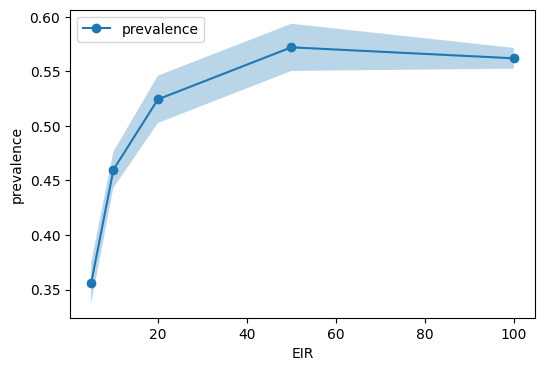

In [19]:
print(f"Loading...", flush=True)
scenarios = pd.read_csv(f'{output}/scenarios.csv')
# df = pd.read_csv(f"{output}/output.csv", compression='gzip')
df = pd.read_hdf(f"{output}/output.h5", key='df')
df.reset_index(drop=True, inplace=True)

# User part below
print(f"Post processing...", flush=True)
df.dropna(inplace=True)

# remove first survey
df.drop(df[df.survey == 1].index, inplace=True)

# reset index
df.reset_index(drop=True, inplace=True)

# Sum the surveys
df = pd.merge(df, scenarios, on='index', how='inner')

nHost = df[df.measure == 0].groupby(['eir', 'seed']).value.sum()
nPatent = df[df.measure == 3].groupby(['eir', 'seed']).value.sum()
prevalence = (nPatent / nHost).groupby('eir')

fig = plt.figure(figsize=(6,4))
plt.plot(prevalence.mean(), marker='o', label=f"prevalence")
plt.fill_between(df.eir.unique(), prevalence.min(), prevalence.max(), alpha=0.3)
plt.xlabel("EIR")
plt.ylabel("prevalence")
plt.legend()